# **CSST106 - Perception and Computer Vision**
##**EXERCISE 3**
###**JONATHAN Q. LAGANZON from BSCS-4B**

**Install necessary libraries**

In [ ]:
!pip install opencv-python matplotlib Pillow
!pip install opencv-python matplotlib scikit-image

**Import libraries**

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage import feature

**Load Image**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
image_path = '/content/drive/MyDrive/2x2/photo_2024-10-26_14-35-28.jpg'
image = Image.open(image_path)

**Convert the image to a NumPy array and then to a BGR format (OpenCV format) and grayscale**

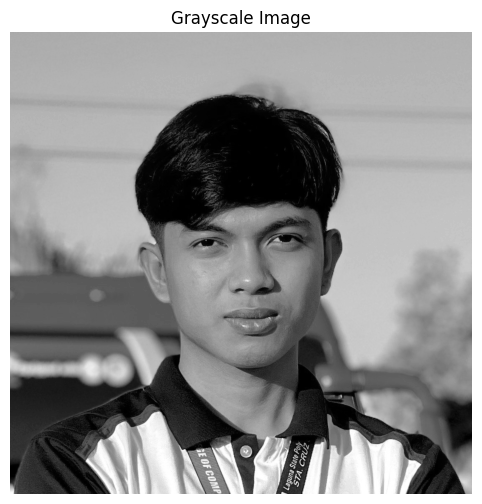

In [ ]:
image = np.array(image)
image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
gray_image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(10, 6))
plt.imshow(gray_image, cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')
plt.show()

#### **Exercise 1: Harris Corner Detection**

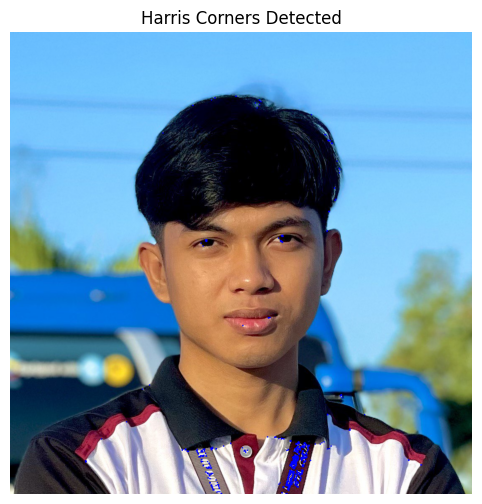

In [ ]:
#Apply Harris Corner Detection.
gray_image_float = np.float32(gray_image)
corners = cv2.cornerHarris(gray_image_float, blockSize=2, ksize=3, k=0.04)

#Dilate the corners to enhance the corner points.
corners = cv2.dilate(corners, None)

#Create a mask for corners.
threshold = 0.01 * corners.max()
image_bgr[corners > threshold] = [255, 0, 0]

#Visualize the results.
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB))
plt.title('Harris Corners Detected')
plt.axis('off')
plt.show()

#### **Exercise 2: HOG (Histogram of Oriented Gradients) Feature Extraction**

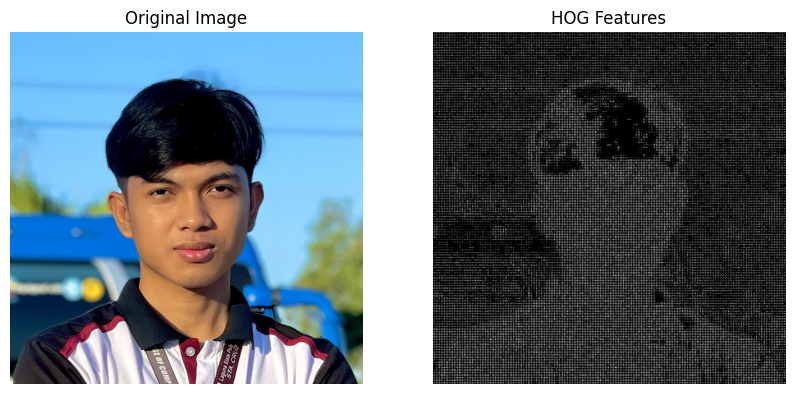

In [ ]:
#Apply HOG descriptor.
hog_features, hog_image = feature.hog(
    gray_image,
    orientations=9,      #Number of orientation bins.
    pixels_per_cell=(8, 8),  #Size of each cell.
    cells_per_block=(2, 2),   #Size of blocks.
    visualize=True       #Visualize the HOG image.
)

#Rescale HOG image to 0-255 for visualization.
hog_image_rescaled = (hog_image * 255).astype(np.uint8)

#Visualize the original image and HOG features.
plt.figure(figsize=(10, 6))

#Original Image.
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

#HOG Features.
plt.subplot(1, 2, 2)
plt.imshow(hog_image_rescaled, cmap='gray')
plt.title('HOG Features')
plt.axis('off')
plt.show()

#### **Exercise 3: FAST (Features from Accelerated Segment Test) Keypoint Detection**

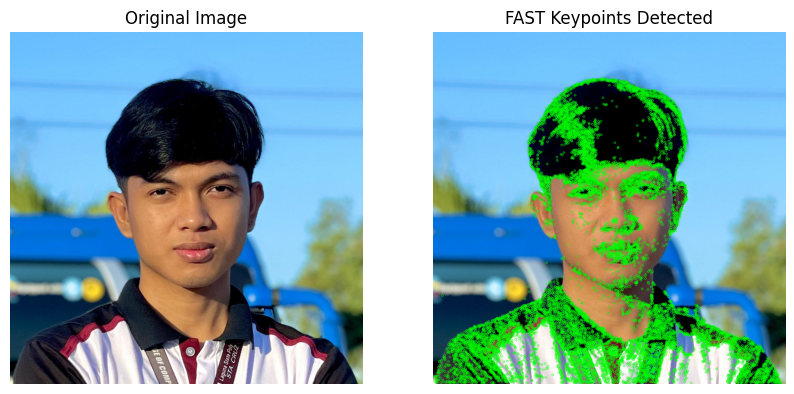

In [ ]:
#Initialize the FAST detector.
fast = cv2.FastFeatureDetector_create()

#Detect keypoints.
keypoints = fast.detect(gray_image, None)

#Draw the keypoints on the image.
image_with_keypoints = cv2.drawKeypoints(image_bgr, keypoints, None, color=(0, 255, 0))

#Visualize the original image and the keypoints.
plt.figure(figsize=(10, 6))

#Original Image.
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

#Image with Keypoints.
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image_with_keypoints, cv2.COLOR_BGR2RGB))
plt.title('FAST Keypoints Detected')
plt.axis('off')
plt.show()

#### **Exercise 4: Feature Matching using ORB and FLANN**

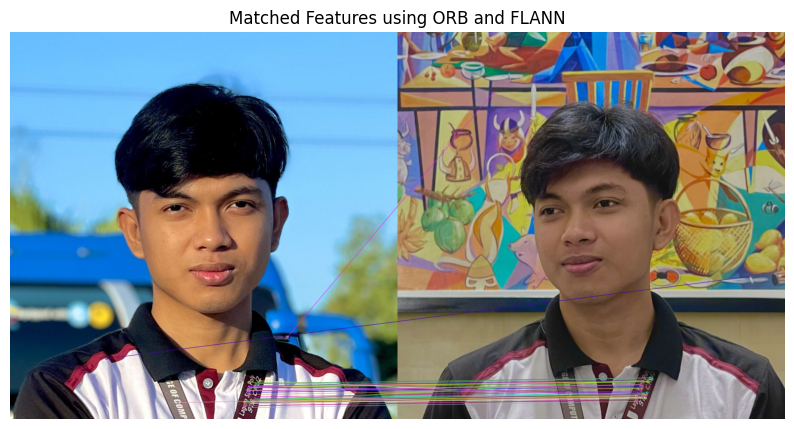

In [ ]:
#Load the two images using PIL.
image_path1 = '/content/drive/MyDrive/2x2/photo_2024-10-26_14-35-28.jpg'
image_path2 = '/content/drive/MyDrive/2x2/photo_2024-10-26_14-44-35.jpg'
image1 = Image.open(image_path1)
image2 = Image.open(image_path2)

#Convert the images to NumPy arrays and then to BGR format (OpenCV format).
image1 = np.array(image1)
image2 = np.array(image2)
image1_bgr = cv2.cvtColor(image1, cv2.COLOR_RGB2BGR)
image2_bgr = cv2.cvtColor(image2, cv2.COLOR_RGB2BGR)

#Resize the images to the same size.
height, width = image1_bgr.shape[:2]
image2_bgr = cv2.resize(image2_bgr, (width, height))

#Initialize ORB detector.
orb = cv2.ORB_create()

#Detect keypoints and compute descriptors for both images.
keypoints1, descriptors1 = orb.detectAndCompute(image1_bgr, None)
keypoints2, descriptors2 = orb.detectAndCompute(image2_bgr, None)

#Create FLANN matcher.
FLANN_INDEX_LSH = 6
index_params = dict(algorithm=FLANN_INDEX_LSH, table_number=6, key_size=12, multi_probe_level=1)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

#Match features between the two images.
matches = flann.knnMatch(descriptors1, descriptors2, k=2)

#Store good matches using the Lowe's ratio test.
good_matches = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good_matches.append(m)

#Draw matches on the images.
matched_image = cv2.drawMatches(image1_bgr, keypoints1, image2_bgr, keypoints2, good_matches, None,
                                 flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

#Visualize the matched features.
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB))
plt.title('Matched Features using ORB and FLANN')
plt.axis('off')
plt.show()

#### **Exercise 5: Image Segmentation using Watershed Algorithm**

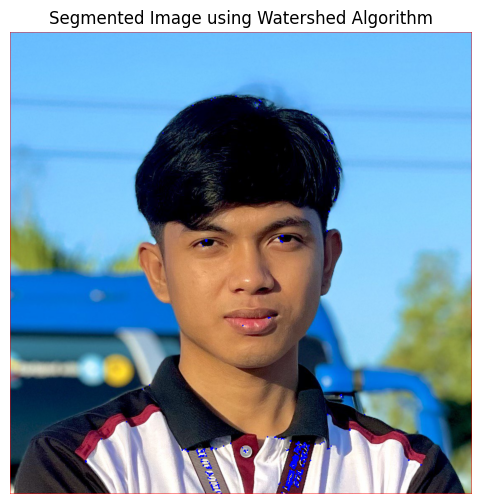

In [ ]:
#Apply thresholding to create a binary image.
_, binary_image = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY_INV)

#Remove noise and prepare for Watershed.
kernel = np.ones((3, 3), np.uint8)
dilated_image = cv2.dilate(binary_image, kernel, iterations=2)
dist_transform = cv2.distanceTransform(dilated_image, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

#Find unknown region.
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(dilated_image, sure_fg)

#Label markers.
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1

#Mark the unknown regions with zero.
markers[unknown == 300] = 0

#Apply the Watershed algorithm.
markers = cv2.watershed(image_bgr, markers)
image_bgr[markers == -1] = [0, 0, 255]

#Visualize the segmented regions.
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB))
plt.title('Segmented Image using Watershed Algorithm')
plt.axis('off')
plt.show()